# Notebook 01: Plot imagery from Cambodia Cube

metadata blah

## Import libraries and create functions

In [1]:
from datacube import Datacube
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import xarray as xr
from datacube_stats.statistics import GeoMedian
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian
from textwrap import wrap
import pickle

In [2]:
#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image_subplots(ds, bands, num_cols, figsize = [20,80], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, 
    and plots them on the RGB bands of an image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
   
    try: #loop through all scenes, prepare imagery and create subplots
        for i, ax in enumerate(fig.axes):
            rgb = ds.isel(time =i).to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
            rgb=rgb.where(rgb>=0)
            fake_saturation = 6000.0
            rgb = rgb.astype('double')
            clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
            max_val = clipped_visible.max(['y', 'x'])
            scaled = (clipped_visible / max_val) 
            ax.imshow(scaled, interpolation = 'nearest') #plot image as subplot
            ax.set_title(str(scaled.time.values)[0:10])
    except IndexError: #if there are an odd number of plots, this code will allow plotting of images
        fig.delaxes(ax)
        plt.draw() 

#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image(ds, bands,title,figsize = [10,10]):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an 
    image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    '''
    rgb = ds.to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
    fake_saturation = 6000.0
    rgb = rgb.astype('double')
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    print(type(clipped_visible))
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)

    fig = plt.figure(figsize = figsize)
    plt.title(title, fontsize=16)
    plt.imshow(scaled)
        
def LoadAreaOfInterest():
    pickle_location=('{0}{1}.pkl'.format(output_folder,study_area))
    try:
        nbar_clean= pickle.load( open(pickle_location, "rb" ) )
        print("reading nbar pickle saved to file")
        return(nbar_clean)
    
    except FileNotFoundError:
        try:
            print("No {0}.pkl file found on file".format(study_area))
            print("Reading location information from AreaOfInterest function")
            lat_min, lat_max, lon_min, lon_max = AreaOfInterest(study_area)
            
#             nbar_clean = DCLoadFunction(cloud_free_threshold)
            
            print("Loading Cambodia Cube data")
            sensor_clean = {}
            #define temporal range ()
            start_of_epoch = '2015-01-01'
            end_of_epoch =  '2018-01-01'

            #define wavelengths/bands of interest
            bands_of_interest = [#'blue',
                                 'green',
                                 'red', 
                                 'nir',
                                 'swir1', 
                                 'pixel_qa',
                                 #'swir2',
                                 ]

            #define Landsat sensors of interest
            sensors = ['ls8',]
            #        'ls7',] 

            #query is created
            query = {'time': (start_of_epoch, end_of_epoch),}
            query['x'] = (lon_min, lon_max)
            query['y'] = (lat_max, lat_min)
            query['crs'] = 'EPSG:4326'

            for sensor in sensors: #loop through specified
                sensor_nbar = cdc.load(product= sensor+'_usgs_sr_scene',
                                       measurements = bands_of_interest,group_by='solar_day', 
                                       **query) #load nbar
                #retrieve the projection information before masking/sorting
                crs = sensor_nbar.crs
                crswkt = sensor_nbar.crs.wkt
                affine = sensor_nbar.affine
                #assign pq data variable
                sensor_pq= sensor_nbar.pixel_qa
                #create and use quality and cloud masks
                mask_components = {'cloud_shadow': 'no_cloud_shadow',
                           'cloud': 'no_cloud',}
                quality_mask = masking.make_mask(sensor_pq, **mask_components)
                good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
                sensor_nbar2 = sensor_nbar.where(good_data)
                #calculate the percentage cloud free for each scene
                cloud_free = masking.make_mask(sensor_pq,
                                               cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
                mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
                #discard data that does not meet the cloud_free_threshold
                mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
                                                                           how='all')
                #assign masked data to array
                sensor_clean[sensor] = mostly_good

                print('loaded %s' % sensor) 
            print('ls load complete')


            #data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor
            nbar_clean = xr.concat(sensor_clean.values(), 'time')
            nbar_clean = nbar_clean.sortby('time')
            nbar_clean.attrs['crs'] = crs
            nbar_clean.attrs['affin|e'] = affine          
                    
            print("saving nbar data as {0}.pkl".format(study_area))

            pickle.dump(nbar_clean, open(pickle_location,"wb")) #save nbar as pickle
            return nbar_clean
        except TypeError:
            print("please add lat/lon details to AreaOfInterest function")

In [3]:
def AreaOfInterest(study_area):
    if study_area == 'phumsrahkaev':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 103.300 #left
        lon_max = 103.400 #right  
    elif study_area == 'outapaong':
        lat_min = 12.600 #down
        lat_max = 12.800 #up
        lon_min = 103.600 #left
        lon_max = 103.800 #right
    else:
        print('FileNotFoundError')
    return (lat_min, lat_max, lon_min, lon_max)

# Define input variables

In [4]:
study_area = 'phumsrahkaev'

cloud_free_threshold = 0.20

#specify output folder to save figures
output_folder= '/g/data/u46/users/ext547/ewater/output_data/image_dump/'

# Query what imagery is  available in Cambodia Cube

## Load Landsat data for specified date range and location

In [5]:
nbar_clean=LoadAreaOfInterest()

No phumsrahkaev.pkl file found on file
Reading location information from AreaOfInterest function
Loading Cambodia Cube data
loaded ls8
ls load complete
saving nbar data as phumsrahkaev.pkl


In [9]:
nbar_clean

<xarray.Dataset>
Dimensions:   (time: 46, x: 365, y: 372)
Coordinates:
  * y         (y) float64 1.449e+06 1.449e+06 1.449e+06 1.449e+06 1.449e+06 ...
  * x         (x) float64 3.156e+05 3.156e+05 3.157e+05 3.157e+05 3.157e+05 ...
  * time      (time) datetime64[ns] 2015-01-22T03:25:46.038450 ...
Data variables:
    green     (time, y, x) float64 1.264e+03 1.19e+03 1.169e+03 1.193e+03 ...
    red       (time, y, x) float64 1.643e+03 1.519e+03 1.511e+03 1.536e+03 ...
    nir       (time, y, x) float64 2.815e+03 2.668e+03 2.761e+03 2.78e+03 ...
    swir1     (time, y, x) float64 3.793e+03 3.635e+03 3.758e+03 3.943e+03 ...
    pixel_qa  (time, y, x) float64 322.0 322.0 322.0 322.0 322.0 322.0 322.0 ...
Attributes:
    crs:      PROJCS["WGS 84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS ...
    affin|e:  | 30.00, 0.00, 315600.00|\n| 0.00,-30.00, 1448820.00|\n| 0.00, ...

## Plot subplots containing all scenes loaded for specified date range and location

<Figure size 1440x5760 with 0 Axes>

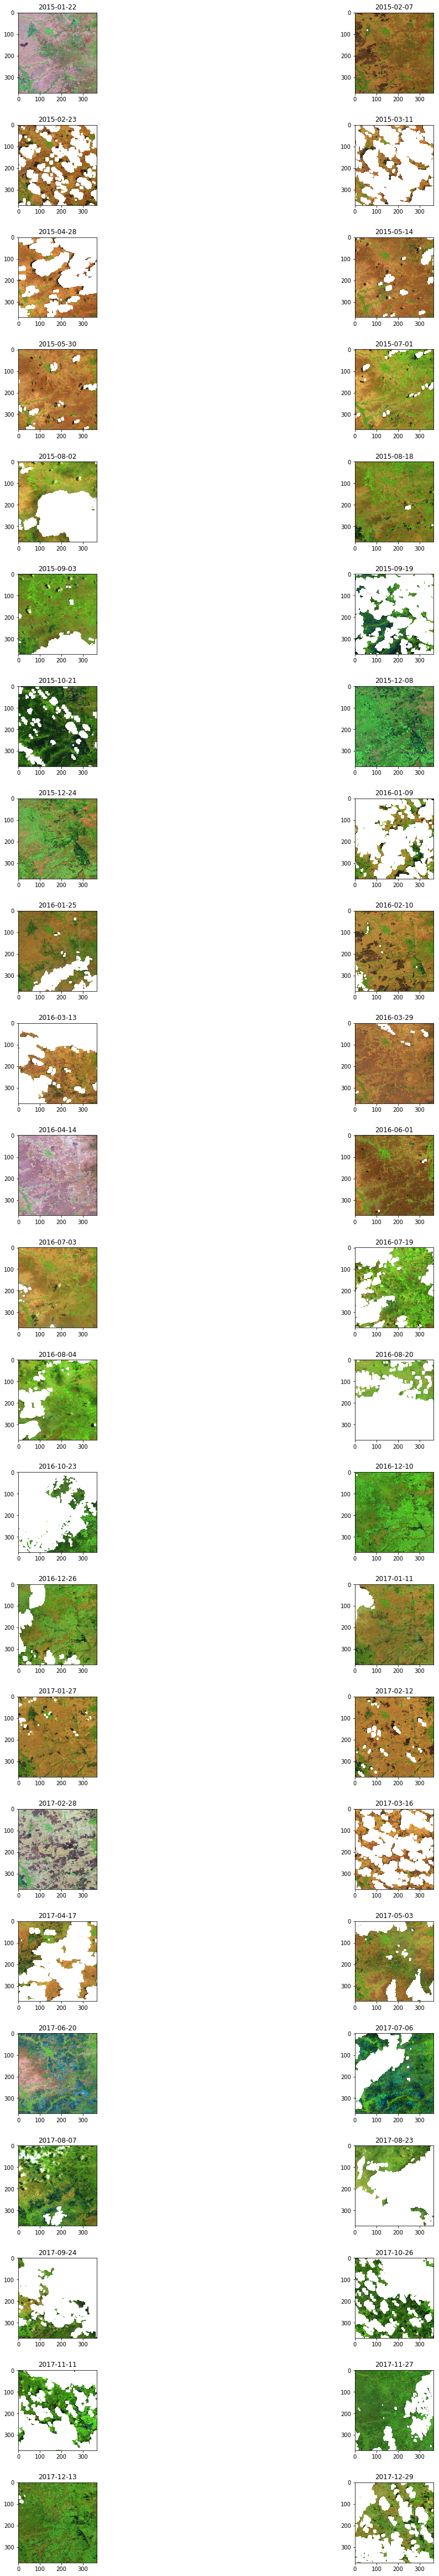

In [10]:
#Use function, defined above, to create three band composites subplot
three_band_image_subplots(nbar_clean, ['swir1','nir', 'green'], 2)

# Create a geomedian image for specified date ranges

In [11]:
#define first time of interest
start_of_time01 = '2015-01-01'
end_of_time01 = '2016-05-01'

#define second time of interest
start_of_time02 = '2016-05-02'
end_of_time02 = '2017-12-31'

In [12]:
#Compute geomedian
# nbar_gm=GeoMedian().compute(nbar_clean)
nbar_gm01=nbar_clean.sel(time = slice(start_of_time01,end_of_time01))
nbar_gm01=GeoMedian().compute(nbar_gm01)

In [13]:
nbar_gm02=nbar_clean.sel(time = slice(start_of_time02,end_of_time02))
nbar_gm02=GeoMedian().compute(nbar_gm02)

## Create geomedian image for the first specified date range

<class 'xarray.core.dataarray.DataArray'>


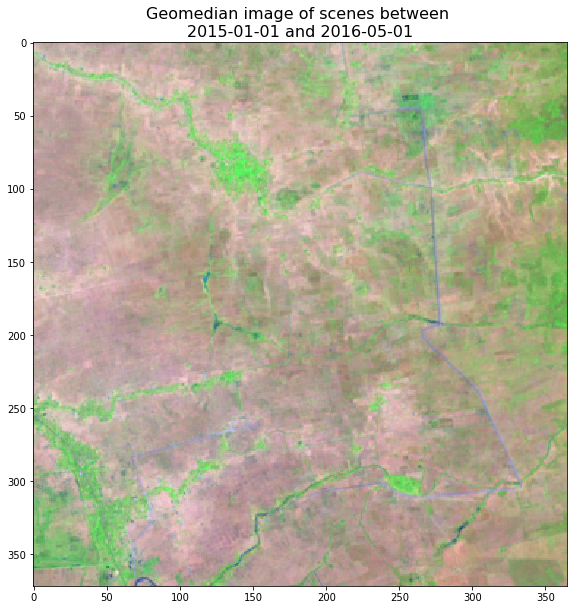

In [14]:
#Use function, defined above, to create a three band composite geomedian image
three_band_image(nbar_gm01,['swir1','nir', 'green'], 
                 title=(str('Geomedian image of scenes between \n{0} and {1}').format(str(start_of_time01),
                                                                               str(end_of_time01))))
plt.savefig('{0}NB01_1_geomedian01{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

## Create geomedian image for the second specified date range

<class 'xarray.core.dataarray.DataArray'>


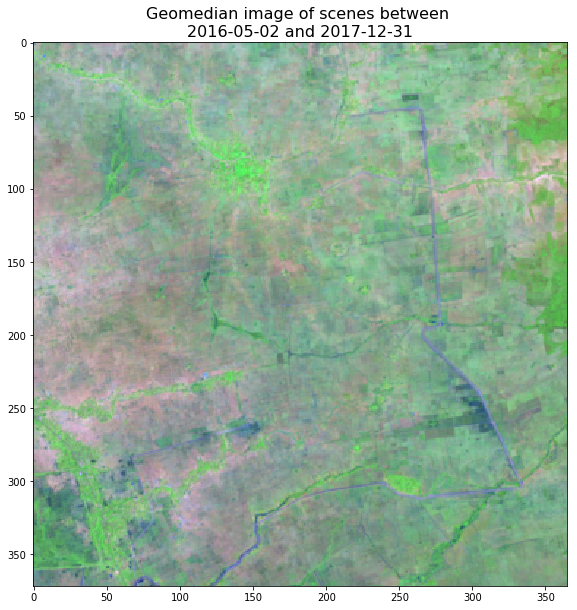

In [15]:
#Use function, defined above, to create a three band composite geomedian image
three_band_image(nbar_gm02,['swir1','nir', 'green'],
                 title=(str('Geomedian image of scenes between \n{0} and {1}').format(str(start_of_time02),
                                                                               str(end_of_time02))))
plt.savefig('{0}NB01_2_geomedian_{1}.jpg'.format(str(output_folder),str(study_area))) #Save figure

# NDWI

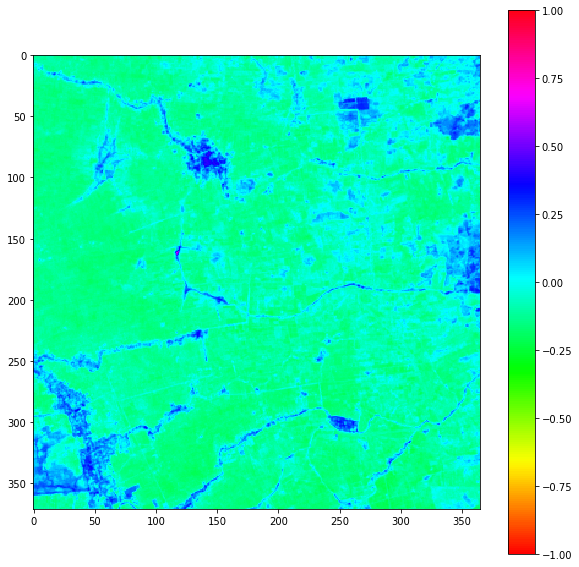

In [16]:
nbar_gm_ndwi01= ((nbar_gm01.nir - nbar_gm01.swir1)/(nbar_gm01.nir+nbar_gm01.swir1))
# nbar_gm_ndwi01= ((nbar_gm01.green - nbar_gm01.nir)/(nbar_gm01.green+nbar_gm01.nir))

fig = plt.figure(figsize=(10,10))
i=plt.imshow(nbar_gm_ndwi01,interpolation = 'nearest',cmap = 'hsv', vmin=-1,vmax=1)
fig.colorbar(i) 

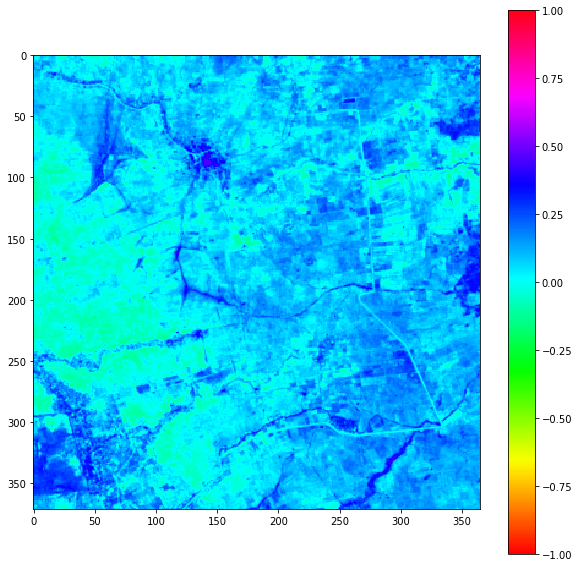

In [17]:
nbar_gm_ndwi02= ((nbar_gm02.nir - nbar_gm02.swir1)/(nbar_gm02.nir+nbar_gm02.swir1))
# nbar_gm_ndwi02= ((nbar_gm02.green - nbar_gm02.nir)/(nbar_gm02.green+nbar_gm02.nir))

fig = plt.figure(figsize=(10,10))
i=plt.imshow(nbar_gm_ndwi02,interpolation = 'nearest', cmap = 'hsv', vmin=-1,vmax=1)
fig.colorbar(i) 